GPU is available and will be used.
Found 7336 images belonging to 6 classes.
Found 150 images belonging to 6 classes.
Found 81 images belonging to 6 classes.
Class indices for the training data: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}


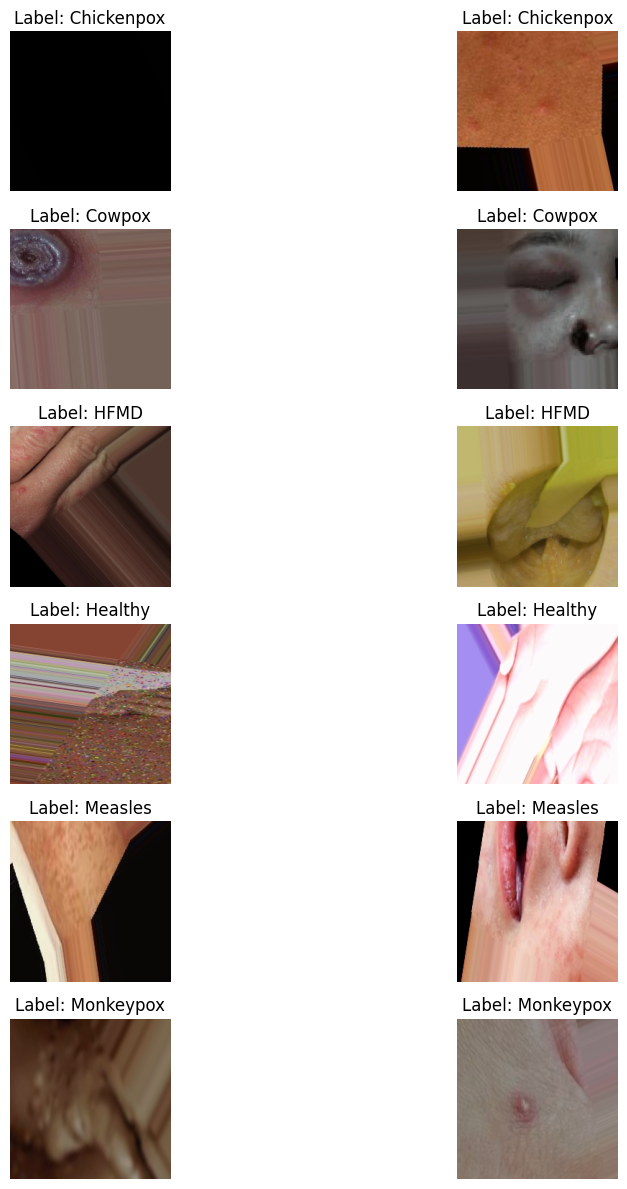

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731037133.854697     115 service.cc:145] XLA service 0x7fbfb40069a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731037133.854776     115 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731037256.694400     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/459 ━━━━━━━━━━━━━━━━━━━━ 26s 446ms/step - accuracy: 0.2502 - loss: 2.5399

I0000 00:00:1731037567.134326     114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 36 bytes spill stores, 36 bytes spill loads



459/459 ━━━━━━━━━━━━━━━━━━━━ 600s 788ms/step - accuracy: 0.2569 - loss: 2.5031 - val_accuracy: 0.3733 - val_loss: 1.9271 - learning_rate: 1.0000e-04
Epoch 2/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 172s 370ms/step - accuracy: 0.4199 - loss: 1.6769 - val_accuracy: 0.4867 - val_loss: 1.5663 - learning_rate: 1.0000e-04
Epoch 3/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 166s 356ms/step - accuracy: 0.5029 - loss: 1.3432 - val_accuracy: 0.4667 - val_loss: 1.6734 - learning_rate: 1.0000e-04
Epoch 4/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 168s 362ms/step - accuracy: 0.5563 - loss: 1.1516 - val_accuracy: 0.5400 - val_loss: 1.5071 - learning_rate: 1.0000e-04
Epoch 5/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 168s 363ms/step - accuracy: 0.6043 - loss: 1.0288 - val_accuracy: 0.5667 - val_loss: 1.3240 - learning_rate: 1.0000e-04
Epoch 6/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 169s 364ms/step - accuracy: 0.6421 - loss: 0.9078 - val_accuracy: 0.5733 - val_loss: 1.2827 - learning_rate: 1.0000e-04
Epoch 7/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 169s 364ms/

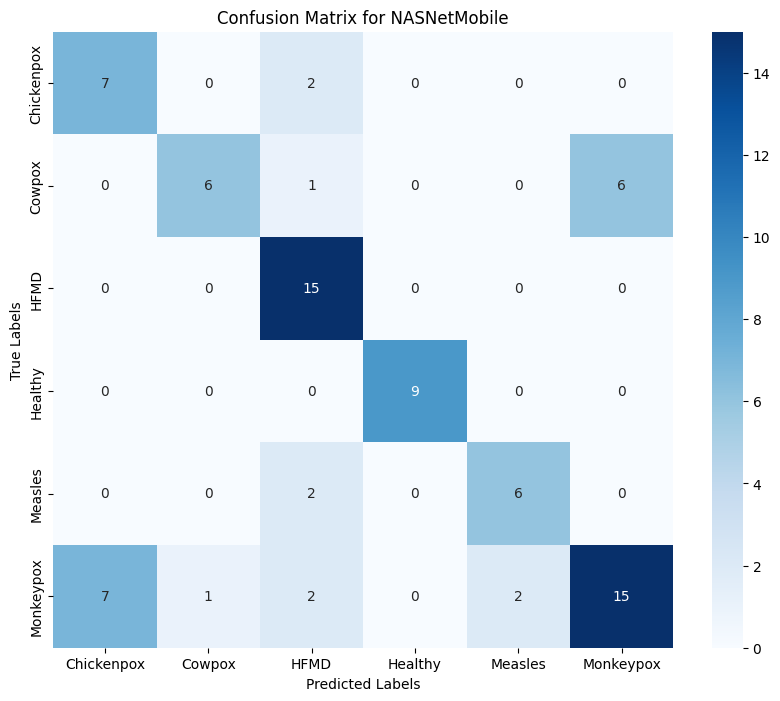

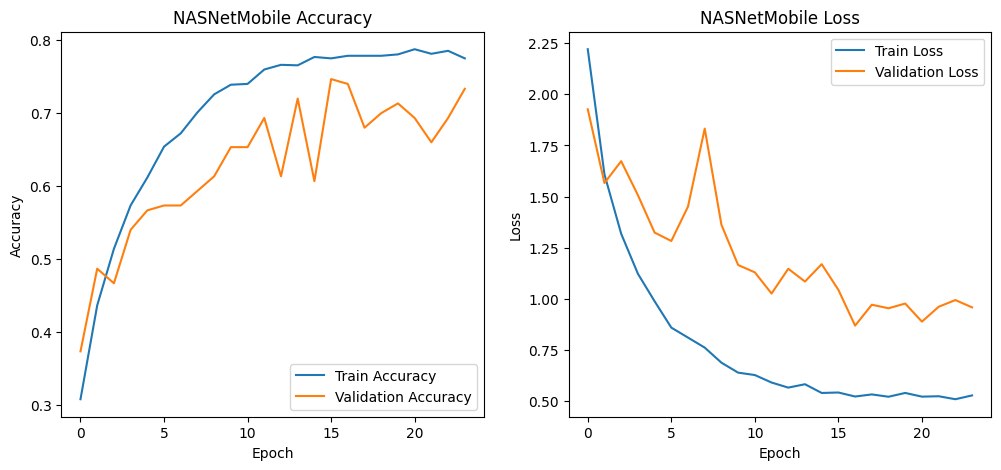

In [1]:
# Import necessary libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available and will be used.")
else:
    print("GPU is not available, using CPU instead.")

# Dataset paths (fold4-selected)
train_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold4_AUG/Train'
valid_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold4/Valid'
test_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold4/Test'

img_size = (224, 224)
batch_size = 16

# Function to create data augmentation pipelines
def augment_class_specific(class_name):
    if class_name in ['Chickenpox', 'Monkeypox']:
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=60,
            width_shift_range=0.5,
            height_shift_range=0.5,
            shear_range=0.4,
            zoom_range=0.5,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.5, 1.5],
            fill_mode='nearest',
            preprocessing_function=lambda img: tf.image.random_contrast(img, lower=0.8, upper=1.2)
        )
    else:
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.4,
            height_shift_range=0.4,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            brightness_range=[0.7, 1.3],
            fill_mode='nearest'
        )

# Test data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Function to load data with class-specific augmentations
def load_data():
    train_datagen = augment_class_specific("Chickenpox")
    validation_datagen = augment_class_specific("Monkeypox")
    
    train_generator = train_datagen.flow_from_directory(
        train_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        valid_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = load_data()

# Check class indices
print(f"Class indices for the training data: {train_generator.class_indices}")

def plot_images_per_class(generator, num_images_per_class=2):
    class_indices = {v: k for k, v in generator.class_indices.items()}
    num_classes = len(class_indices)
    images_per_class = {class_name: [] for class_name in class_indices.values()}

    while any(len(images) < num_images_per_class for images in images_per_class.values()):
        images, labels = next(generator)
        for img, label in zip(images, labels):
            class_label = np.argmax(label)
            class_name = class_indices[class_label]
            if len(images_per_class[class_name]) < num_images_per_class:
                images_per_class[class_name].append(img)

    plt.figure(figsize=(12, num_classes * 2))
    img_idx = 1
    for class_name, images in images_per_class.items():
        for img in images:
            plt.subplot(num_classes, num_images_per_class, img_idx)
            img_idx += 1
            if img.max() > 1:
                img = img / 255.0
            plt.imshow(img)
            plt.title(f"Label: {class_name}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 2 images from each class from the training set
plot_images_per_class(train_generator, num_images_per_class=2)

# Compute class weights
labels = train_generator.classes
class_weights_nasnet = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(labels), 
                                                  y=labels)
class_weights_dict_nasnet = dict(enumerate(class_weights_nasnet))

# Build the NASNetMobile model
def build_nasnet_model(input_shape=(224, 224, 3), num_classes=6):
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Fine-tune the last 100 layers
    for layer in base_model.layers[-100:]:
        layer.trainable = True
    
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Build the model
model_nasnet = build_nasnet_model()

# Callbacks for early stopping, learning rate reduction, and model checkpoint
checkpoint_nasnet = ModelCheckpoint("best_model_nasnet.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_nasnet = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler_nasnet = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model with class weights and callbacks
history_nasnet = model_nasnet.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights_dict_nasnet,
    callbacks=[checkpoint_nasnet, early_stopping_nasnet, lr_scheduler_nasnet]
)

# Evaluate the model on the test set
test_loss_nasnet, test_acc_nasnet = model_nasnet.evaluate(test_generator)
print(f"Test accuracy: {test_acc_nasnet}")

# Save the final model
model_nasnet.save('final_nasnet_model.keras')

# Predictions on the test set
preds_nasnet = model_nasnet.predict(test_generator)
y_preds_nasnet = np.argmax(preds_nasnet, axis=1)
y_true_nasnet = test_generator.classes

# Classification report
print("Classification Report for NASNetMobile Model:")
print(classification_report(y_true_nasnet, y_preds_nasnet, target_names=test_generator.class_indices.keys()))

# Compute accuracy, precision, recall, and F1-score
accuracy_nasnet = accuracy_score(y_true_nasnet, y_preds_nasnet)
precision_nasnet = precision_score(y_true_nasnet, y_preds_nasnet, average='weighted', zero_division=0)
recall_nasnet = recall_score(y_true_nasnet, y_preds_nasnet, average='weighted', zero_division=0)
f1_nasnet = f1_score(y_true_nasnet, y_preds_nasnet, average='weighted', zero_division=0)

print(f"Precision: {precision_nasnet}")
print(f"Recall: {recall_nasnet}")
print(f"F1 Score: {f1_nasnet}")

# Confusion matrix
cm_nasnet = confusion_matrix(y_true_nasnet, y_preds_nasnet)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_nasnet, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for NASNetMobile')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Function to plot training history
def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot training history
plot_training_history(history_nasnet, model_name="NASNetMobile")